In [2]:
import time
from __future__ import print_function
import keras
from keras.layers import Dense, Conv2D, BatchNormalization, Activation
from keras.layers import AveragePooling2D, Input, Flatten
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras.callbacks import ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator
from keras.regularizers import l2
from keras import backend as K
from keras.models import Model
from keras.datasets import cifar100, cifar10
import numpy as np
import os, sys
import math
from keras.preprocessing.image import ImageDataGenerator,array_to_img,img_to_array,load_img
from sklearn.decomposition import PCA
import lid
from lid import LID
import matplotlib.pyplot as plt
from matplotlib import ticker, cm

/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [4]:
batch_size = 16
num_classes = 10
# Subtracting pixel mean improves accuracy
subtract_pixel_mean = True
# exp_name = 'Aug_resNet_Cifar10_BS%d_epochs%d' % (batch_size, epochs)

In [5]:
# Load the CIFAR10 data.
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
print(x_train.shape,y_train.shape)
# Input image dimensions.
input_shape = x_train.shape[1:]
x_train_ori = x_train
y_train_ori = y_train
# Normalize data.
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

# If subtract pixel mean is enabled
x_train_mean = np.mean(x_train, axis=0)
if subtract_pixel_mean:
    x_train -= x_train_mean
    x_test -= x_train_mean

# Convert class vectors to binary class matrices.
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

train_num,test_num = x_train.shape[0],x_test.shape[0]

print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')
print('y_train shape:', y_train.shape)


(50000, 32, 32, 3) (50000, 1)
x_train shape: (50000, 32, 32, 3)
50000 train samples
10000 test samples
y_train shape: (50000, 10)


# batch lid值较大图像

In [6]:
iteration=int(x_train.shape[0]/batch_size)
from progressbar import ProgressBar
pbar = ProgressBar()
outlier_mask=np.zeros(train_num,dtype=int)
for i in pbar(range(iteration)):
    mask=np.random.choice(train_num,batch_size,True)
    x_batch = x_train[mask].reshape(batch_size,-1)
    k=(int)(math.sqrt(batch_size))
    dis = LID(x_batch,x_batch,k)
    dis_idx = np.argwhere(dis>np.percentile(dis,99))
    batch_outlier_mask=mask[dis_idx]
    outlier_mask[batch_outlier_mask]+=1

100% |########################################################################|


(3012,)
[22342 47458 16031 36994 41044 28480 30533 36942 31502  9261 13497 19323
 29649  2114 48638  8990 39198 29646 37444 11622 25433 45081 26668 31959
  6368]


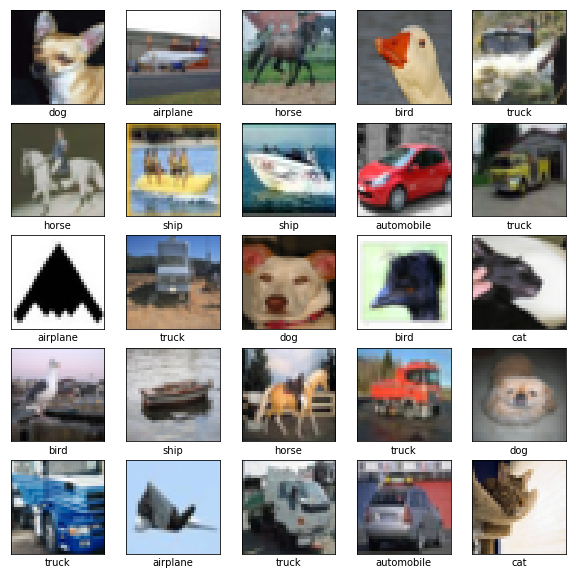

In [7]:
import numpy as np
print(np.argwhere(outlier_mask!=0).flatten().shape)
outlier_idx = np.argwhere(outlier_mask!=0).flatten()
random_outlier = np.random.choice(outlier_idx,25,replace=False)
print(random_outlier)
plt.figure(figsize=(10,10))
cifar10_labels=["airplane","automobile","bird","cat","deer","dog","frog","horse","ship","truck"]
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(x_train_ori[random_outlier[i]], cmap=plt.cm.binary)
    label = np.argwhere(y_train[random_outlier[i]]==1.0).flatten()[0]
    plt.xlabel(cifar10_labels[label])

# batch lid值正常图像

(46983,)
[ 4302 32543  4301  1595 39272 19271 20134 39370 32831 26038 43190 11171
 10084 37190 31589 47444  8142 21332 44658 40734 36016 13091 11729 18179
 45922]


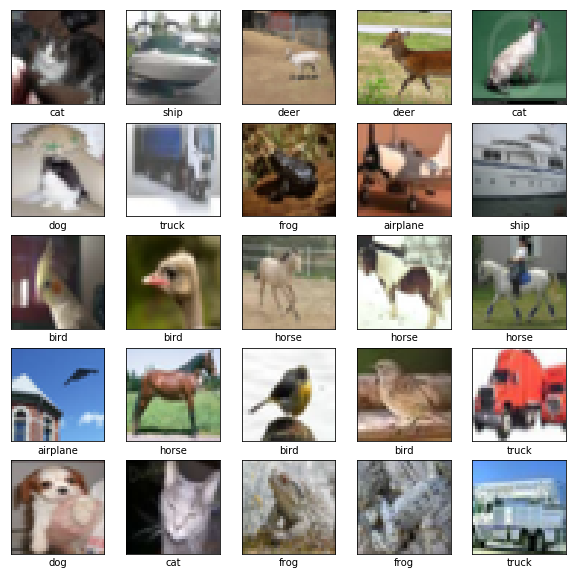

In [63]:
normal_idx = np.argwhere(outlier_mask==0).flatten()
print(normal_idx.shape)
random_normal = np.random.choice(normal_idx,25,replace=False)
print(random_normal)
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(x_train_ori[random_normal[i]], cmap=plt.cm.binary)
    label = np.argwhere(y_train[random_normal[i]]==1.0).flatten()[0]
    plt.xlabel(cifar10_labels[label])

# batch lid值较小图像

In [64]:
# from progressbar import ProgressBar
# pbar = ProgressBar()
# best_mask=np.zeros(train_num,dtype=int)
# for i in pbar(range(iteration)):
#     mask=np.random.choice(train_num,batch_size,True)
#     x_batch = x_train[mask].reshape(batch_size,-1)
#     k=(int)(math.sqrt(batch_size))
#     dis = LID(x_batch,x_batch,k)
#     dis_idx = np.argwhere(dis<np.percentile(dis,10))
#     batch_best_mask=mask[dis_idx]
#     best_mask[batch_best_mask]+=1

In [65]:
# print(np.argwhere(best_mask!=0).flatten().shape)
# best_idx = np.argwhere(best_mask!=0).flatten()
# random_best = np.random.choice(best_idx,25,replace=False)
# print(random_outlier)
# plt.figure(figsize=(10,10))
# for i in range(25):
#     plt.subplot(5,5,i+1)
#     plt.xticks([])
#     plt.yticks([])
#     plt.grid(False)
#     plt.imshow(x_train_ori[random_best[i]], cmap=plt.cm.binary)
#     label = np.argwhere(y_train[random_best[i]]==1.0).flatten()[0]
#     plt.xlabel(cifar10_labels[label])

# 以类别为单位的高质量图像（去除cls lid值最高的1%样本，val acc下降6%）

In [69]:
cls_high_lid_idx = np.zeros(x_train.shape[0])
x_train = x_train_ori
y_train = y_train_ori
from progressbar import ProgressBar
pbar = ProgressBar()
for cls in pbar(range(10)):
    cls_train_idx = y_train.flatten()==cls
    cls_train_idx = np.argwhere(cls_train_idx==1).flatten()
    x_cls_train = x_train[cls_train_idx]
    iteration = int(x_cls_train.shape[0]/batch_size)
    for i in range(iteration):
        x_cls_train_batch_idx = np.random.choice(cls_train_idx,batch_size,True)
        x_cls_train_batch = x_train[x_cls_train_batch_idx].reshape(batch_size,-1)
        k = int(math.sqrt(batch_size))
        dis = LID(x_cls_train_batch, x_cls_train_batch, k)  # 也可以和validation计算
        dis_idx = np.argwhere(dis > np.percentile(dis,99)).flatten()    # 选择cls lid最高的1%
        cls_high_lid_idx[x_cls_train_batch_idx[dis_idx]] += 1
cls_high_lid_sample_num = np.argwhere(cls_high_lid_idx!=0).flatten().shape[0]

100% |########################################################################|


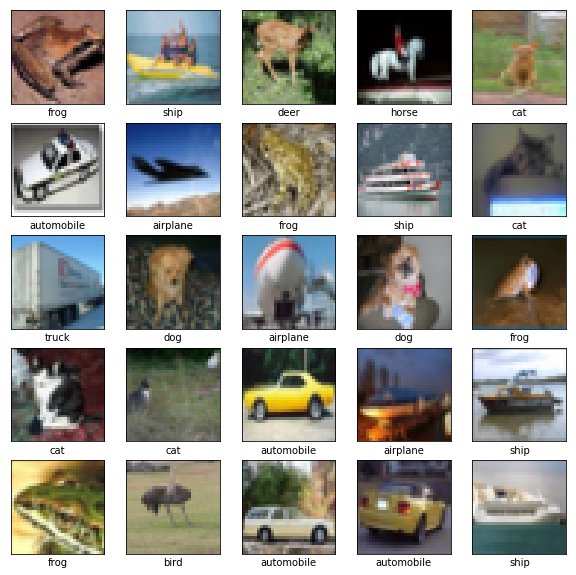

In [70]:
random_best = np.random.choice(cls_high_lid_sample_num,25,replace=False)
cifar10_labels=["airplane","automobile","bird","cat","deer","dog","frog","horse","ship","truck"]
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(x_train[random_best[i]], cmap=plt.cm.binary)
    label = y_train[random_best[i]][0]
    plt.xlabel(cifar10_labels[label])

# class&batch高lid样本重合度分析

In [71]:
# 便于理解所以定义了一个新变量，实际上outlier_mask保存的就是batch中lid最高的1%样本下标
batch_high_lid_idx = outlier_mask
print("class high lid num:",np.argwhere(cls_high_lid_idx!=0).shape[0])
print("batch high lid num:",np.argwhere(batch_high_lid_idx!=0).shape[0])
cache_batch_high_lid_idx = batch_high_lid_idx!=0
cache_cls_high_lid_idx = cls_high_lid_idx!=0
cache_batch_high_lid_idx = cache_batch_high_lid_idx * 1
cache_cls_high_lid_idx = cache_cls_high_lid_idx * 1
com = cache_batch_high_lid_idx + cache_cls_high_lid_idx
print("common high lid sample num:",np.argwhere(com==2).shape[0])

class high lid num: 2976
batch high lid num: 3017
common high lid sample num: 220


# 读取data augmentation数据

In [ ]:
x_train_augmentation = np.load("../Cifar10_Aug/aug_train_x.npy")

In [ ]:
y_train_augmentation = np.load("../Cifar10_Aug/aug_train_y.npy")

# Data Augmentation LID高值

In [ ]:
from progressbar import ProgressBar
pbar = ProgressBar()
high_mask=np.zeros(x_train_augmentation.shape[0],dtype=int)
iteration = int(x_train_augmentation.shape[0]/10/batch_size)
dis_high_global = []
for i in pbar(range(iteration)):
    mask=np.random.choice(x_train_augmentation.shape[0],batch_size,True)
    x_batch = x_train_augmentation[mask].reshape(batch_size,-1)
    k=(int)(math.sqrt(batch_size))
    dis = LID(x_batch,x_batch,k)
    dis_high_global.extend(dis)
    dis_idx = np.argwhere(dis>np.percentile(dis,90))
    batch_best_mask=mask[dis_idx]
    high_mask[batch_best_mask]+=1

In [ ]:
high_idx = np.argwhere(high_mask!=0).flatten()
random_high = np.random.choice(high_idx,25,replace=False)
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    tmp = np.asarray(x_train_augmentation[random_high[i]], dtype=np.int)
    plt.imshow(tmp)
    label = y_train_augmentation[random_high[i]][0]
    plt.xlabel(cifar10_labels[label])

# lid分布直方图

In [ ]:
binwidth=1
dis_high_global = np.asarray(dis_high_global, dtype=np.int)
plt.hist(dis_high_global, bins=range(min(dis_high_global), int(max(dis_high_global)/10) + binwidth, binwidth))

# Data Augmentation 随机挑选

In [ ]:
normal_idx = np.random.choice(x_train_augmentation.shape[0],25,replace=False)
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    tmp = np.asarray(x_train_augmentation[normal_idx[i]], dtype=np.int)
    plt.imshow(tmp)
    label = y_train_augmentation[normal_idx[i]][0]
    plt.xlabel(cifar10_labels[label])

In [ ]:
from progressbar import ProgressBar
pbar = ProgressBar()
iteration = int(x_train_augmentation.shape[0]/10/batch_size)
dis_normal_global = []
for i in pbar(range(iteration)):
    mask=np.random.choice(x_train_augmentation.shape[0],batch_size,True)
    x_batch = x_train_augmentation[mask].reshape(batch_size,-1)
    k=(int)(math.sqrt(batch_size))
    dis = LID(x_batch,x_batch,k)
    dis_normal_global.extend(dis)

# Data Augmentation LID低值

In [ ]:
from progressbar import ProgressBar
pbar = ProgressBar()
low_mask=np.zeros(x_train_augmentation.shape[0],dtype=int)
iteration = int(x_train_augmentation.shape[0]/10/batch_size)
dis_low_global = []
for i in pbar(range(iteration)):
    mask=np.random.choice(x_train_augmentation.shape[0],batch_size,True)
    x_batch = x_train_augmentation[mask].reshape(batch_size,-1)
    k=(int)(math.sqrt(batch_size))
    dis = LID(x_batch,x_batch,k)
    dis_idx = np.argwhere(dis<np.percentile(dis,10))
    batch_best_mask=mask[dis_idx]
    low_mask[batch_best_mask]+=1

In [ ]:
low_idx = np.argwhere(low_mask!=0).flatten()
random_low = np.random.choice(low_idx,25,replace=False)
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    tmp = np.asarray(x_train_augmentation[random_low[i]], dtype=np.int)
    plt.imshow(tmp)
    label = y_train_augmentation[random_low[i]][0]
    plt.xlabel(cifar10_labels[label])